# 3D Reconstruction
Now that we have the silhuettes we can now extract the visual hull of the object. Do so we need the camera intrinsic parameters and the extrinsic paramters. Our simulation pipeline already provides us with a json file for that. A python script then can be ran to extract the camera intrinsics

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from src.camera_data import CamerasData
from src.scans import Scans
from src.convex_hull import project_scan
from src.algebra import invert_extrinsic_matrix
from src.mesh import build_mesh

example_camera = 9

## 1. Data Classes
To do the reconstruction we need to organize our data into clear but usefull classes. This will include our Camera Data (`CameraData`) and our Pictures (`Scans`)

### 1.1. Camera Data
For the reconstruction we need:
- Camera Intrinsics
- Extrinsics Parameters

The camera intrinsics are defined by the matrix K and the extrinsics are defined by the individual camera positions (4x4 matrix). All of this is managed by the class ```CameraData```

In [8]:
camera_data = CamerasData("../blender_simulator/simulated_frames/dataset_d30/camera_intrinsics.json", "../blender_simulator/simulated_frames/dataset_d30/transforms_train.json")

In [9]:
print(f"K Matrix:\n{camera_data.K}\n")
print(f'Extrinsic Matrix of Camera {example_camera}\n{camera_data.get_camera_extrinsics(example_camera)}\n')
print(f'With shape: {camera_data.extrinsics_array.shape}')

K Matrix:
[[2.66666667e+03 0.00000000e+00 9.60000000e+02]
 [0.00000000e+00 2.66666667e+03 5.40000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Extrinsic Matrix of Camera 9
[[-2.55564927e-02  9.99673333e-01 -1.90020346e-11  2.55564927e-02]
 [ 1.39246336e-02  3.55981117e-04  9.99902945e-01 -1.39246336e-02]
 [ 9.99576401e-01  2.55540150e-02 -1.39291832e-02 -9.99576401e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

With shape: (12, 4, 4)


**Projection Matrix**<br>
By combining both matrices we can have the projection matrix

In [10]:
P = camera_data.P(0)

print(f'Projection Matyrix of Camera 0\n{P}\n')
print(f'With shape: {P.shape}')

Projection Matyrix of Camera 0
[[ 2.67029241e+03 -9.49767711e+02 -1.37792674e+01 -9.49767711e+02]
 [ 2.19573324e+00 -5.78215909e+02  2.65864107e+03 -5.78215909e+02]
 [ 3.79700905e-03 -9.99889700e-01 -1.43534035e-02 -9.99889700e-01]]

With shape: (3, 4)


### 1.2 Scans
Scans should have all the segemntations from the pictures taken. It holds the data as a binary array [0 or 1]

In [5]:
scans = Scans("../3d_reconstruction/figures/reconstruction_d30/segmented")

Number of scans: 12
Dimension of each scan: (1080, 1920)
Values in the first scan: [0 1]


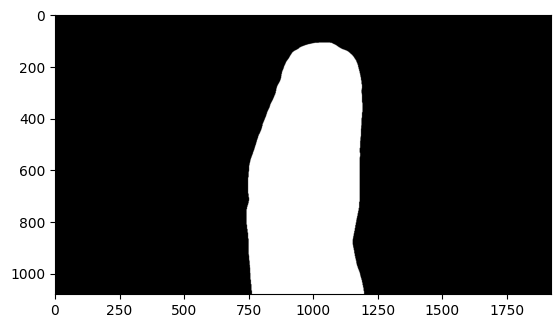

In [6]:
print(f"Number of scans: {scans.nr_positions}")
print(f"Dimension of each scan: {scans.scan_shape}")
print(f"Values in the first scan: {np.unique(scans.scan(0))}")

plt.imshow(scans.scan(0), cmap='gray')

## 2. Convex Hull
This will take the data and apply the convex hull algorithm

### 2.1. Projecting Single Point
Before we compute any reconstruction we should just test projecting some points (like origin) to check if the matrices are ok. In this process it was found that the `transformation_matrix` produced by **BlenderNeRF** was not world to camera but rather camera to world. This is fixed now when the camera data is initialized  

Projecting 3D Point: [0 0 0]

Projection Coordinates X1 : -891.0, X2 : -577.0, X3 : -1.0
Image Coordinates (np.float64(892.0), np.float64(577.0))


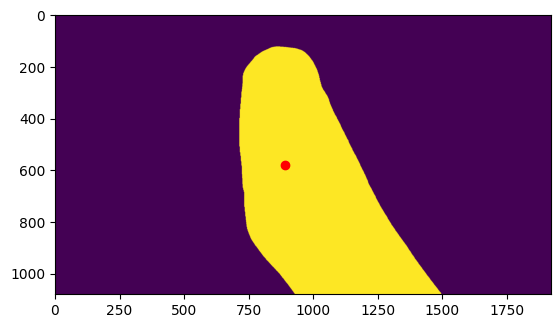

In [11]:
P = camera_data.P(example_camera)
point_3d = np.array([0,0,0,1])
print(f"Projecting 3D Point: {point_3d[:3]}\n")

# Projecting
x1, x2, x3 = P @ point_3d
print(f"Projection Coordinates X1 : {np.round(x1)}, X2 : {np.round(x2)}, X3 : {np.round(x3)}")
print(f"Image Coordinates {np.round(x1/x3), np.round(x2/x3)}")

# Plotting
plt.imshow(scans.scan(example_camera))
plt.scatter(x1//x3, x2/x3, color='red')

### 2.2. Obtaining Single Convex Hull
Let's see if we can map a grid of points in other to build the first building block in the reconstruction pipeline

In [10]:
from src.convex_hull import *

In [17]:
def project_scan(camera_data: CamerasData, scans: Scans, camera_nr: int, resolution: int, reconstruction_range: float) -> tuple[np.ndarray, float]:
    """
    Project a 3D scan data into a volumetric representation using camera projection.
    This function takes camera calibration data and scan measurements to create
    a 3D volume by projecting world coordinates to image coordinates and
    accumulating scan values at corresponding voxels.

    Parameters
    ----------
    camera_data : CamerasData
        Container holding camera calibration parameters including projection
        matrices for multiple cameras.
    camera_nr : int
        The index/identifier of the camera to use for projection.
    scans : Scans
        Container holding scan data for multiple cameras/positions.
    resolution : int
        The number of voxels along each axis of the 3D reconstruction volume.
        Creates a resolution×resolution×resolution grid.
    reconstruction_range : float
        The physical extent of the reconstruction volume in world coordinates.
        Defines the cube size from -reconstruction_range to +reconstruction_range.

    Returns
    -------
    tuple[np.ndarray, float]
        A tuple containing:
        - camera_volume : np.ndarray
            3D volume of shape (resolution, resolution, resolution) with
            accumulated scan values at each voxel position.
        - voxel_size : float
            The physical size of each voxel in world coordinate units.

    Notes
    -----
    - Uses the camera's projection matrix P to transform 3D world coordinates
      to 2D image coordinates.
    - Only voxels that project to valid image coordinates (within scan bounds)
      contribute to the volume.
    - Progress is displayed using tqdm for the outer loop over x-coordinates.
    - The function assumes homogeneous coordinates (4D) for 3D points.

    Examples
    --------
    >>> volume, voxel_size = project_scan(cameras, scans, 0, 128, 5.0)
    >>> volume.shape
    (128, 128, 128)
    >>> # voxel_size represents the spacing between adjacent voxels
    """
    # Data extraction
    scan = scans.scan(camera_nr)
    P = camera_data.P(camera_nr)
    projected_points = []

    # Generate world coordinate grid
    coord_matrix_map, coord_range = generate_worl_grid_cube(resolution, reconstruction_range)
    camera_volume = np.zeros(coord_matrix_map.shape[:3], dtype=int)
    voxel_size = coord_range[1] - coord_range[0]

    # Project each voxel to image and accumulate scan values
    for idx, x in enumerate(tqdm(coord_range, desc=f"🔄 Processing Slices fo Camera Nr {camera_nr}")):
        for idy, y in enumerate(coord_range):
            for idz, z in enumerate(coord_range):
                point_3d = np.array([x, y, z, 1])
                u,v = project_world_to_image(point_3d, P)
                point_mag = np.linalg.norm(point_3d[:3])
                projected_points.append((u,v, point_mag))
                

                is_valid = (u is not None and v is not None) and (0 <= u < scan.shape[1]) and (0 <= v < scan.shape[0])
                if is_valid: camera_volume[idx, idy, idz] += scan[v, u]
    
    return camera_volume, voxel_size, projected_points

🔄 Processing Slices fo Camera Nr 0: 100%|██████████| 50/50 [00:00<00:00, 87.49it/s]

Voxel Size: 0.018 m with Volume: 6196.398 mm³ per Voxel


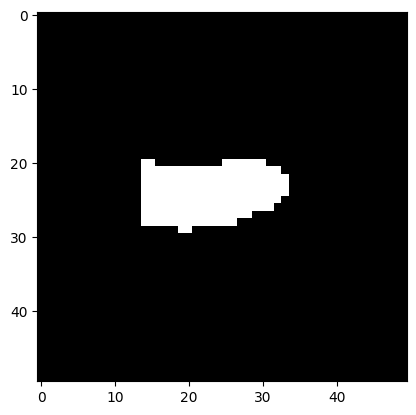

In [18]:
camera_volume, voxel_size, projected_points = project_scan(camera_data, scans, 0, resolution=50, reconstruction_range=0.45)

print(f"Voxel Size: {np.round(voxel_size,3)} m with Volume: {np.round(voxel_size**3 * 1e9, 3)} mm³ per Voxel")

plt.imshow(camera_volume[:, 50//2, :], cmap='gray')

In [11]:
projected_points = np.array(projected_points)

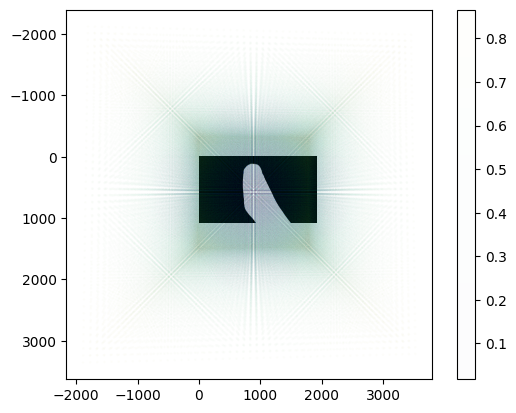

In [12]:
plt.imshow(scans.scan(9), cmap='gray')
plt.scatter(projected_points[:, 0], projected_points[:, 1], c=projected_points[:, 2], s=1, alpha=0.01)
plt.colorbar()

### 2.3. Object Reconstruction

In [12]:
full_volume = []
resolution = 200
reconstruction_range = 0.45

for camera_nr in range(camera_data.nr_cameras):
    camera_volume, voxel_size = project_scan(camera_data, scans, camera_nr, resolution=resolution, reconstruction_range=reconstruction_range)
    build_mesh(camera_volume, file_name=f"{resolution}_volume_{camera_nr}_mesh.ply", verbose=0)
    full_volume.append(camera_volume)
    

🔄 Processing Slices fo Camera Nr 11: 100%|██████████| 200/200 [00:13<00:00, 14.95it/s]


In [13]:
full_volume = np.array(full_volume)
print(f"Full Volume Shape: {full_volume.shape}")

Full Volume Shape: (12, 200, 200, 200)


In [14]:
sum_volume = np.sum(full_volume, axis=0)
print(f"Summed Volume Shape: {sum_volume.shape}")

Summed Volume Shape: (200, 200, 200)


In [15]:
convex_hull = np.where(sum_volume > 10, 1, 0)
print(f"Convex Hull Shape: {convex_hull.shape}")
print(f"Number of Voxels in Convex Hull: {np.sum(convex_hull)}")

Convex Hull Shape: (200, 200, 200)
Number of Voxels in Convex Hull: 68148


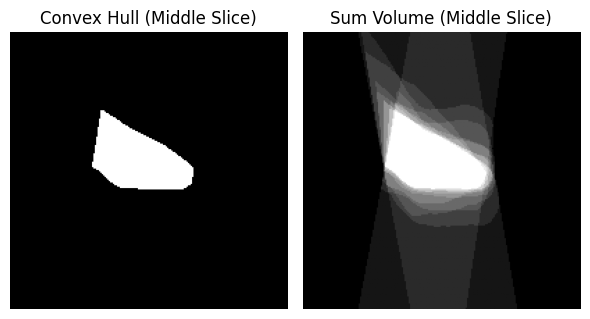

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4))

axes[0].imshow(convex_hull[resolution//2, :, :], cmap='gray')
axes[0].set_title('Convex Hull (Middle Slice)')
axes[0].axis('off')

axes[1].imshow(sum_volume[resolution//2, :, :], cmap='gray')
axes[1].set_title('Sum Volume (Middle Slice)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [17]:
build_mesh(convex_hull, file_name="full_convex_hull_mesh.ply", verbose=1)

✅ Finished exporting blender/full_convex_hull_mesh.ply
Mesh vertices: 14124, faces: 28244


<trimesh.Trimesh(vertices.shape=(14124, 3), faces.shape=(28244, 3))>

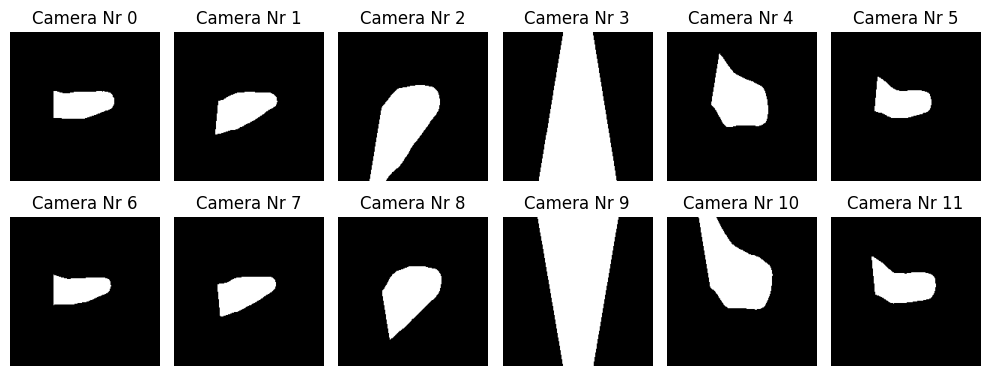

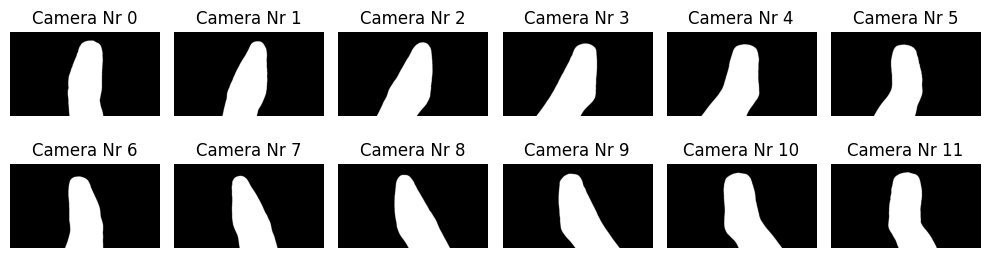

In [18]:
fig, axes = plt.subplots(2, 6, figsize=(10, 4))
axes = axes.flatten()

for camera in range(camera_data.nr_cameras):
    axes[camera].set_title(f"Camera Nr {camera}")
    axes[camera].imshow(full_volume[camera, :, resolution//2, :], cmap='gray')
    axes[camera].axis('off')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 6, figsize=(10, 3))
axes = axes.flatten()

for camera in range(camera_data.nr_cameras):
    axes[camera].set_title(f"Camera Nr {camera}")
    axes[camera].imshow(scans.scan(camera), cmap='gray')
    axes[camera].axis('off')

plt.tight_layout()
plt.show()

In [55]:
for camera in range(camera_data.nr_cameras):
    print(f"Camera Nr {camera}\nExtrinsics:\n{camera_data.get_camera_extrinsics(camera)}\n")
    R = camera_data.get_camera_extrinsics(camera)[:3, :3]
    euler_angles = np.round(euler_from_matrix(R, order="XYZ", degrees=True),2)  # Blender default
    print(f"Angles (XYZ): {euler_angles}\n\n")

Camera Nr 0
Extrinsics:
[[ 9.99992847e-01  3.79740074e-03 -3.63797881e-12  3.79740074e-03]
 [ 5.45056282e-05 -1.43533014e-02  9.99897003e-01 -1.43533014e-02]
 [ 3.79700959e-03 -9.99889851e-01 -1.43534066e-02 -9.99889851e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Angles (XYZ): [-90.82  -0.22   0.  ]


Camera Nr 1
Extrinsics:
[[ 8.61065686e-01 -5.08493781e-01 -4.65661287e-10 -9.86170982e-03]
 [-7.28784548e-03 -1.23409843e-02  9.99897361e-01 -1.43288388e-02]
 [-5.08441567e-01 -8.60977232e-01 -1.43322209e-02 -9.99661281e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Angles (XYZ): [-90.95  30.56  -0.48]


Camera Nr 2
Extrinsics:
[[ 0.48193851 -0.87620503  0.         -0.02069978]
 [-0.01245331 -0.00684969  0.99989909 -0.01420707]
 [-0.87611651 -0.48188984 -0.01421278 -0.9994973 ]
 [ 0.          0.          0.          1.        ]]

Angles (XYZ): [-91.69  61.18  -1.48]


Camera Nr 3
Extrinsics:
[[-2.57461872e-02 -9.99668479e-01  0.0000

In [47]:
R = camera_data.get_camera_extrinsics(0)[:3, :3]
Rt = R.T
print( np.round(R @ Rt) )  # Should be identity

[[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]


In [11]:
def is_rotation_matrix(R, tol=1e-6):
    """Quick sanity check for a proper rotation matrix."""
    if R.shape != (3, 3):
        return False
    should_be_I = R.T @ R
    I = np.eye(3)
    return np.linalg.norm(should_be_I - I) < tol and np.linalg.det(R) > 0

In [12]:
def clamp(x, lo, hi):
    return max(lo, min(hi, x))

def euler_from_matrix(R, degrees=False):
    """
    Convert a 3x3 rotation matrix to Euler angles in the given intrinsic order.
    
    Parameters
    ----------
    R : (3,3) ndarray
        Rotation matrix (assumed proper: R^T R = I, det(R)=+1).
    order : str
        Intrinsic rotation order. Supported: "XYZ" (Blender default), "ZYX".
        - "XYZ" means rotate around local X, then local Y, then local Z.
        - "ZYX" means rotate around local Z, then local Y, then local X.
    degrees : bool
        If True, return angles in degrees. Otherwise radians.
    
    Returns
    -------
    (a, b, c) : tuple of floats
        Euler angles (intrinsic) for the chosen order.
        For Blender default "XYZ": (x, y, z).
    """
    R = np.asarray(R, dtype=float)
    if not is_rotation_matrix(R): raise ValueError("Input is not a proper rotation matrix (orthogonal with det +1).")

    # Numerical tolerance for gimbal detection
    eps = 1e-9

    sy = -R[2,0]
    sy = clamp(sy, -1.0, 1.0)  # numerical safety
    y = np.arcsin(sy)
    cy = np.cos(y)

    if abs(cy) > eps:
        x = np.arctan2(R[2,1], R[2,2])
        z = np.arctan2(R[1,0], R[0,0])
    else:
        # Gimbal lock (cy ~ 0): y ≈ ±pi/2
        # Collapse one DOF; choose z = 0 and compute x from a stable pair
        x = np.arctan2(-R[1,2], R[1,1])
        z = 0.0

    angles = (x, y, z)

    if degrees:
        angles = tuple(np.degrees(a) for a in angles)

    return angles




In [53]:
euler_angles = np.round(euler_from_matrix(R, order="XYZ", degrees=True),2)  # Blender default

print(f"Angles (XYZ): {euler_angles}\n")
print(f"Translation Vector (XYZ): {camera_data.get_camera_extrinsics(0)[:3, 3]} m")

Angles (XYZ): [-90.82  -0.22   0.  ]

Translation Vector (XYZ): [ 0.0037974  -0.0143533  -0.99988985] m


In [39]:
import json

# Open and read a JSON file
with open('../blender_simulator/camera_extrinsics.json', 'r') as file:
    data = json.load(file)

In [40]:
from src.algebra import invert_extrinsic_matrix

In [41]:
nr_test_cameras = len(data['cameras'])

for cam_idx in range(nr_test_cameras):
    test_matrix_01 = np.round(np.array(data['cameras'][cam_idx]['frames']['transform_matrix']),2)
    R_test_01 = test_matrix_01[:3, :3]
    t_test_01 = test_matrix_01[:3, 3]

    test_euler_angles_01 = np.round(euler_from_matrix(R_test_01, degrees=True),2)


    print(f"Test Matrix Euler Angles (XYZ): {test_euler_angles_01}")
    print(f"Test Matrix Translation Vector (XYZ): {t_test_01} m")
    print(test_matrix_01, '\n')

Test Matrix Euler Angles (XYZ): [90. -0.  0.]
Test Matrix Translation Vector (XYZ): [ 0. -2.  0.] m
[[ 1.  0.  0.  0.]
 [ 0. -0. -1. -2.]
 [ 0.  1. -0.  0.]
 [ 0.  0.  0.  1.]] 

Test Matrix Euler Angles (XYZ): [ 90.  -0. -90.]
Test Matrix Translation Vector (XYZ): [-2.  0.  0.] m
[[-0. -0. -1. -2.]
 [-1.  0.  0.  0.]
 [ 0.  1. -0.  0.]
 [ 0.  0.  0.  1.]] 

Test Matrix Euler Angles (XYZ): [  90.   -0. -180.]
Test Matrix Translation Vector (XYZ): [0. 2. 0.] m
[[-1. -0. -0.  0.]
 [-0.  0.  1.  2.]
 [ 0.  1. -0.  0.]
 [ 0.  0.  0.  1.]] 

Test Matrix Euler Angles (XYZ): [90. -0. 90.]
Test Matrix Translation Vector (XYZ): [2. 0. 0.] m
[[-0.  0.  1.  2.]
 [ 1.  0.  0.  0.]
 [ 0.  1. -0.  0.]
 [ 0.  0.  0.  1.]] 



In [42]:
nr_test_cameras = len(data['cameras'])

for cam_idx in range(nr_test_cameras):
    test_matrix_01 = np.round(np.array(data['cameras'][cam_idx]['frames']['transform_matrix']),2)
    test_matrix_01 = invert_extrinsic_matrix(test_matrix_01)
    R_test_01 = test_matrix_01[:3, :3]
    t_test_01 = test_matrix_01[:3, 3]

    test_euler_angles_01 = np.round(euler_from_matrix(R_test_01, degrees=True),2)


    print(f"Test Matrix Euler Angles (XYZ): {test_euler_angles_01}")
    print(f"Test Matrix Translation Vector (XYZ): {t_test_01} m")
    print(test_matrix_01, '\n')

Test Matrix Euler Angles (XYZ): [-90.  -0.   0.]
Test Matrix Translation Vector (XYZ): [ 0.  0. -2.] m
[[ 1.  0.  0.  0.]
 [ 0. -0.  1.  0.]
 [ 0. -1. -0. -2.]
 [ 0.  0.  0.  1.]] 

Test Matrix Euler Angles (XYZ): [-90.  90.   0.]
Test Matrix Translation Vector (XYZ): [ 0.  0. -2.] m
[[-0. -1.  0.  0.]
 [-0.  0.  1.  0.]
 [-1.  0. -0. -2.]
 [ 0.  0.  0.  1.]] 

Test Matrix Euler Angles (XYZ): [  90.    0. -180.]
Test Matrix Translation Vector (XYZ): [ 0.  0. -2.] m
[[-1. -0.  0.  0.]
 [-0.  0.  1.  0.]
 [-0.  1. -0. -2.]
 [ 0.  0.  0.  1.]] 

Test Matrix Euler Angles (XYZ): [-90. -90.   0.]
Test Matrix Translation Vector (XYZ): [ 0.  0. -2.] m
[[-0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 1.  0. -0. -2.]
 [ 0.  0.  0.  1.]] 



In [37]:
import numpy as np

def camworld_to_worldcam(Mw: np.ndarray, *, to_opencv: bool=True, assume_rigid: bool=True) -> np.ndarray:
    """
    Mw: 4x4 Blender camera->world matrix (mathutils.Matrix or np.ndarray).
    Returns 4x4 world->camera extrinsic in Blender cam frame (x right, y up, z back),
    or OpenCV frame (x right, y down, z forward) if to_opencv=True.
    """
    Mw = np.array(Mw, dtype=float)
    if Mw.shape != (4,4):
        raise ValueError("Mw must be 4x4 camera->world")

    R_wc = Mw[:3, :3]
    C    = Mw[:3,  3]  # camera center in world coords

    if assume_rigid:
        # Project to nearest rotation (removes tiny scale/shear)
        U, _, Vt = np.linalg.svd(R_wc)
        R_wc = U @ Vt
        if np.linalg.det(R_wc) < 0:   # enforce right-handed
            U[:, -1] *= -1
            R_wc = U @ Vt
        R_cw = R_wc.T
        t_cw = -R_cw @ C
        E = np.eye(4)
        E[:3,:3] = R_cw
        E[:3,  3] = t_cw
    else:
        # Full affine inverse (works if Mw has scale/shear from parents)
        E = np.linalg.inv(Mw)

    if to_opencv:
        A = np.diag([1.0, -1.0, -1.0])  # flip Y,Z: Blender-cam -> OpenCV
        E[:3,:3] = A @ E[:3,:3]
        E[:3,  3] = A @ E[:3,  3]

    return E

test_matrix = np.round(np.array(data['cameras'][3]['frames']['transform_matrix']),2)
test_matrix = camworld_to_worldcam(test_matrix)

In [38]:
print(np.round(test_matrix,2))

[[ 0.  1.  0.  0.]
 [ 0.  0. -1.  0.]
 [-1.  0.  0.  2.]
 [ 0.  0.  0.  1.]]
